## Contents
##### [Importing Libraries](#Libraries)
##### [Loading the data and cleaning](#Loading-the-data)
##### [Text preprocess functions](#Text-preprocess-functions)
##### [Bag-of-Words -  all documents](#Bag-of-Words)
##### [TF-IDF prep](#TF-IDF)
##### [LDA model](#LDA)
##### [LDA + TF-IDF model](#LDA-+-TF-IDF)
##### [Testing the models](#Testing)
##### [Test on documents from current news](#Test-on-new-documents)
##### [Clustering ](#Clustering)
##### [Building the dataframe for the clustering ](#Building-the-dataframe-for-the-clustering)
##### [Getting the confidences to each topic ](#Getting-the-confidences-to-each-topic)
##### [Clustering](#Clustering1)
##### [PCA + Graphs](#Applying-PCA)
##### [LDA with TF_LDF ](#LDA-with-TF_LDF)
##### [Clustering](#Clustering2)
##### [PCA + Graphs](#Applying-PCA-2)

#### Libraries

In [8]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import string
import gensim
import matplotlib.pyplot as plt

from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from nltk import pos_tag, word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim import corpora, models
from nltk.stem.porter import *

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Busss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Busss\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Loading the data

In [9]:
df = pd.read_csv('data/data.csv')
df.shape

C:\Users\Busss\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(204135, 12)

In [10]:
df.head()

,id,title,author,date,content,year,month,publication,category,digital,section,url
0,1,Agent Cooper in Twin Peaks is the audience: on...,\nTasha Robinson\n,2017-05-31,And never more so than in Showtime’s new...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN
1,2,"AI, the humanity!",\nSam Byford\n,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN
2,3,The Viral Machine,\nKaitlyn Tiffany\n,2017-05-25,Super Deluxe built a weird internet empi...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN
3,4,How Anker is beating Apple and Samsung at thei...,\nNick Statt\n,2017-05-22,Steven Yang quit his job at Google in th...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN
4,5,Tour Black Panther’s reimagined homeland with ...,\nKwame Opam\n,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN


#### Removing all columns and keeping only the 'content' column

In [11]:
remove = [i for i in df.columns if i!='content']

In [12]:
df.drop(remove, axis = 1, inplace=True)
df.head()

,content
0,And never more so than in Showtime’s new...
1,AlphaGo’s victory isn’t a defeat for hum...
2,Super Deluxe built a weird internet empi...
3,Steven Yang quit his job at Google in th...
4,Ahead of Black Panther’s 2018 theatrical...


In [13]:
df.shape

(204135, 1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204135 entries, 0 to 204134
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  188732 non-null  object
dtypes: object(1)
memory usage: 1.6+ MB


In [15]:
df.dropna(inplace=True)

In [16]:
df.shape

(188732, 1)

#### Text preprocess functions

In [17]:
stemmer = SnowballStemmer("english")

def lem_stem(word):
    return stemmer.stem(WordNetLemmatizer().lemmatize(word))

def preprocess(text):
    return [lem_stem(token) for token in gensim.utils.simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3]            


#### Checking the functions at work

In [18]:
print('original:',df['content'].iloc[3][:100])
print("after:",preprocess(df['content'].iloc[3][:100]))

original:       Steven Yang quit his job at Google in the summer of 2011 to build the products he felt the wor
after: ['steven', 'yang', 'quit', 'googl', 'summer', 'build', 'product', 'felt']


#### Preprocessing the data

In [19]:
pp_data = df['content'].map(preprocess)

In [20]:
pp_data[:10]

0    [showtim, seri, reviv, spoiler, ahead, episod,...
1    [alphago, victori, defeat, human, opportun, lo...
2    [super, delux, built, weird, internet, empir, ...
3    [steven, yang, quit, googl, summer, build, pro...
4    [ahead, black, panther, theatric, releas, marv...
5    [facebook, instant, articl, promis, transform,...
6    [weapon, weapon, year, artist, technolog, enth...
7    [insid, busi, imagin, futur, dubai, world, loo...
8    [legal, threat, disgruntl, client, insid, uber...
9    [genius, quiet, laid, bunch, engin, surviv, me...
Name: content, dtype: object

#### Bag-of-Words

In [21]:
dict_of_words = gensim.corpora.Dictionary(pp_data)

In [22]:
for i, (key, value) in enumerate(dict_of_words.iteritems()):
    print(key, value)
    if i == 10:
        break

0 abandon
1 abil
2 absenc
3 acknowledg
4 act
5 activ
6 actual
7 adventur
8 age
9 agenc
10 agent


#### Total number of words in dict:

In [23]:
print('total:',len(dict_of_words.iteritems()))

total: 319212


#### Filter out tokens
remove < 'no_below', 
remove > 'no_above',
then keep only the first 'keep_n' most

In [24]:
dict_of_words.filter_extremes(no_below=15, no_above=0.1, keep_n=50000)

In [25]:
bow_for_docs = [dict_of_words.doc2bow(i) for i in pp_data]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 8),
  (8, 1),
  (9, 1),
  (10, 2),
  (11, 1),
  (12, 1),
  (13, 2),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 14),
  (19, 1),
  (20, 1),
  (21, 3),
  (22, 2),
  (23, 2),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 2),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 2),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 2),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 2),
  (49, 5),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 6),
  (63, 1),
  (64, 2),
  (65, 1),
  (66, 1),
  (67, 3),
  (68, 1),
  (69, 1),
  (70, 2),
  (71, 1),
  (72, 32),
  (73, 1),
  (74, 1),
  (75, 2),
  (76, 1),
  (77, 7),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 2),
  (84, 1),
  (85, 2),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 

#### How many words in the title at the i-th location
(i==2 in this case)

In [26]:
len(bow_for_docs[3])

471

#### Check the words at that location
(id, count)

##### Ordered by how they appear in the content - top 10

In [27]:
bow_for_docs[3][:10]

[(10, 1),
 (17, 1),
 (40, 3),
 (41, 14),
 (44, 1),
 (45, 4),
 (60, 1),
 (67, 16),
 (70, 2),
 (111, 1),
 (112, 1),
 (121, 1),
 (133, 5),
 (134, 1),
 (137, 1),
 (150, 1),
 (162, 2),
 (165, 3),
 (167, 1),
 (185, 1),
 (200, 1),
 (203, 1),
 (213, 3),
 (217, 1),
 (222, 1),
 (227, 1),
 (234, 1),
 (238, 1),
 (253, 2),
 (257, 1),
 (260, 4),
 (262, 1),
 (270, 2),
 (271, 1),
 (274, 1),
 (278, 1),
 (279, 3),
 (283, 1),
 (298, 1),
 (312, 1),
 (317, 1),
 (322, 1),
 (339, 1),
 (348, 1),
 (374, 1),
 (376, 1),
 (377, 3),
 (383, 1),
 (398, 1),
 (410, 1),
 (413, 1),
 (418, 1),
 (421, 1),
 (429, 1),
 (431, 4),
 (432, 7),
 (439, 2),
 (441, 2),
 (446, 1),
 (450, 1),
 (461, 1),
 (466, 2),
 (470, 1),
 (475, 1),
 (483, 2),
 (490, 1),
 (495, 2),
 (496, 6),
 (500, 1),
 (505, 2),
 (508, 1),
 (523, 1),
 (525, 1),
 (527, 2),
 (534, 1),
 (538, 2),
 (553, 1),
 (555, 1),
 (559, 22),
 (560, 1),
 (565, 1),
 (570, 2),
 (576, 1),
 (588, 2),
 (593, 1),
 (594, 1),
 (595, 10),
 (608, 1),
 (610, 2),
 (613, 1),
 (616, 1),
 (61

##### Ordered by the most frequent - top 10

In [28]:
sorted(bow_for_docs[3],  key=lambda x: x[1], reverse=True)[:10]

[(992, 51),
 (1013, 32),
 (1320, 29),
 (559, 22),
 (1036, 20),
 (67, 16),
 (887, 15),
 (41, 14),
 (981, 14),
 (652, 11)]

##### Ordered by the least frequent - top 10

In [29]:
sorted(bow_for_docs[3],  key=lambda x: x[1])[:10]

[(10, 1),
 (17, 1),
 (44, 1),
 (60, 1),
 (111, 1),
 (112, 1),
 (121, 1),
 (134, 1),
 (137, 1),
 (150, 1)]

#### Check the actual words

In [30]:
limit = 10
space = '     '
tmp_words = bow_for_docs[3]

print(f' LOC  |   WORD NUMBER   |    WORD FREQ    | THE ACTUAL WORD ')
print('-------------------------------------------------------------')
for i in range(len(tmp_words)):
    num = str(tmp_words[i][0])
    while len(num) < 5: num = ' '+num
        
    freq = str(tmp_words[i][1])
    while len(freq) < 5: freq = ' '+freq

    loc = str(i)
    while len(loc) < 5: loc = ' '+loc

    print(f'{loc} | {space}{num}{space} | {space}{freq}{space} | {space}{dict_of_words[tmp_words[i][0]]}')
    if i == limit: break
print(tmp_words)

 LOC  |   WORD NUMBER   |    WORD FREQ    | THE ACTUAL WORD 
-------------------------------------------------------------
    0 |         10      |          1      |      alien
    1 |         17      |          1      |      aspect
    2 |         40      |          3      |      built
    3 |         41      |         14      |      cabl
    4 |         44      |          1      |      capabl
    5 |         45      |          4      |      capac
    6 |         60      |          1      |      color
    7 |         67      |         16      |      consum
    8 |         70      |          2      |      convinc
    9 |        111      |          1      |      eventu
   10 |        112      |          1      |      exact
[(10, 1), (17, 1), (40, 3), (41, 14), (44, 1), (45, 4), (60, 1), (67, 16), (70, 2), (111, 1), (112, 1), (121, 1), (133, 5), (134, 1), (137, 1), (150, 1), (162, 2), (165, 3), (167, 1), (185, 1), (200, 1), (203, 1), (213, 3), (217, 1), (222, 1), (227, 1), (234, 1), (23

### TF-IDF

In [31]:
idf = models.TfidfModel(bow_for_docs)

##### Transforming

In [32]:
tdf_data = idf[bow_for_docs]

##### (id, score)

In [33]:
for i in tdf_data:
    print(i)
    break

[(0, 0.015478959057446923), (1, 0.012365447563896025), (2, 0.01890746695108075), (3, 0.012502690603094915), (4, 0.011984062827162469), (5, 0.020523541608644492), (6, 0.015227182589769604), (7, 0.11081895116417972), (8, 0.011921362809765527), (9, 0.01665278701142758), (10, 0.03410854322226277), (11, 0.018483863961796826), (12, 0.016047319220607432), (13, 0.034013609410010866), (14, 0.012789150604182389), (15, 0.016250003948498216), (16, 0.0316115763113638), (17, 0.016496878996472127), (18, 0.18158696326799126), (19, 0.027367336605085904), (20, 0.019546777774875762), (21, 0.0742679533618682), (22, 0.031015388537486425), (23, 0.026869514749103846), (24, 0.021000730869090756), (25, 0.03046593774327872), (26, 0.02038032475300019), (27, 0.013288816494756946), (28, 0.022541512871759723), (29, 0.021959038197401203), (30, 0.018645903434227902), (31, 0.011829266273268656), (32, 0.04139491682670043), (33, 0.01984032567888331), (34, 0.016582602982426465), (35, 0.026315185252322112), (36, 0.0206505

### LDA
Training

In [34]:
lda = gensim.models.LdaMulticore(bow_for_docs, num_topics=5, id2word=dict_of_words, passes=10, workers=6)

##### Lets view the words

In [35]:
for i, topic in lda.print_topics(-1):
    print(f"Topic: {i} \nWords: {topic}\n---\n")

Topic: 0 
Words: 0.004*"film" + 0.003*"season" + 0.003*"music" + 0.003*"movi" + 0.003*"player" + 0.002*"charact" + 0.002*"mother" + 0.002*"girl" + 0.002*"artist" + 0.002*"father"
---

Topic: 1 
Words: 0.007*"russia" + 0.007*"russian" + 0.005*"reuter" + 0.005*"korea" + 0.004*"intellig" + 0.004*"china" + 0.004*"judg" + 0.004*"attorney" + 0.004*"lawyer" + 0.003*"nuclear"
---

Topic: 2 
Words: 0.005*"islam" + 0.004*"shoot" + 0.004*"syria" + 0.004*"arrest" + 0.004*"muslim" + 0.004*"crime" + 0.003*"prison" + 0.003*"refuge" + 0.003*"violenc" + 0.003*"isi"
---

Topic: 3 
Words: 0.004*"price" + 0.004*"food" + 0.004*"water" + 0.003*"drug" + 0.003*"medic" + 0.003*"patient" + 0.003*"worker" + 0.003*"stock" + 0.002*"sale" + 0.002*"test"
---

Topic: 4 
Words: 0.005*"student" + 0.005*"sander" + 0.004*"poll" + 0.004*"cruz" + 0.004*"nomine" + 0.004*"educ" + 0.003*"colleg" + 0.003*"primari" + 0.003*"liber" + 0.003*"nomin"
---



#### Topic Classification

In [36]:
'Topic: 0 Words: 0.015*"player" + 0.012*"season" + 0.009*"sport" + 0.008*"leagu" + 0.007*"coach" + 0.007*"olymp" + 0.006*"athlet" + 0.005*"footbal" + 0.005*"field" + 0.005*"ball"'

'Topic: 0 Words: 0.015*"player" + 0.012*"season" + 0.009*"sport" + 0.008*"leagu" + 0.007*"coach" + 0.007*"olymp" + 0.006*"athlet" + 0.005*"footbal" + 0.005*"field" + 0.005*"ball"'

### LDA + TF-IDF
Training

In [37]:
lda_idf = gensim.models.LdaMulticore(tdf_data, num_topics=5, id2word=dict_of_words, passes=15, workers=6)

In [38]:
for i, topic in lda_idf.print_topics(-1):
    print(f"Topic: {i} \nWords: {topic}\n---\n")

Topic: 0 
Words: 0.009*"islam" + 0.008*"syria" + 0.007*"syrian" + 0.007*"isi" + 0.005*"muslim" + 0.005*"turkey" + 0.005*"bomb" + 0.005*"iraq" + 0.005*"milit" + 0.005*"iraqi"
---

Topic: 1 
Words: 0.002*"film" + 0.002*"music" + 0.002*"season" + 0.001*"movi" + 0.001*"player" + 0.001*"artist" + 0.001*"charact" + 0.001*"song" + 0.001*"sport" + 0.001*"girl"
---

Topic: 2 
Words: 0.003*"russia" + 0.003*"russian" + 0.003*"sander" + 0.002*"korea" + 0.002*"poll" + 0.002*"cruz" + 0.002*"comey" + 0.002*"nomine" + 0.002*"intellig" + 0.002*"nuclear"
---

Topic: 3 
Words: 0.004*"student" + 0.003*"drug" + 0.002*"shoot" + 0.002*"medic" + 0.002*"counti" + 0.002*"patient" + 0.002*"judg" + 0.002*"crime" + 0.002*"arrest" + 0.002*"prison"
---

Topic: 4 
Words: 0.004*"reuter" + 0.003*"price" + 0.003*"bank" + 0.003*"insur" + 0.002*"stock" + 0.002*"china" + 0.002*"appl" + 0.002*"thomson" + 0.002*"investor" + 0.002*"growth"
---



#### Topic Classification

In [39]:
'Topic: 0 Words: 0.010*"olymp" + 0.009*"yanke" + 0.008*"player" + 0.007*"athlet" + 0.007*"met" + 0.006*"cuban" + 0.006*"cuba" + 0.006*"basebal" + 0.006*"leagu" + 0.006*"season"'

'Topic: 0 Words: 0.010*"olymp" + 0.009*"yanke" + 0.008*"player" + 0.007*"athlet" + 0.007*"met" + 0.006*"cuban" + 0.006*"cuba" + 0.006*"basebal" + 0.006*"leagu" + 0.006*"season"'

### Testing
###### Using these parameters

In [40]:
loc = 321
tmp_doc = pp_data[loc]
print(tmp_doc)

['today', 'releas', 'movi', 'trailer', 'entertain', 'event', 'unto', 'hype', 'teas', 'huge', 'plot', 'inform', 'dump', 'hour', 'hour', 'scene', 'scene', 'analysi', 'fact', 'wasn', 'like', 'fact', 'movi', 'trailer', 'simpler', 'straightforward', 'voic', 'explain', 'audienc', 'movi', 'littl', 'stylist', 'flourish', 'grant', 'today', 'center', 'evolut', 'hollywood', 'blockbust', 'specif', 'star', 'war', 'perfect', 'embodi', 'promo', 'clip', 'break', 'ground', 'onlin', 'distribut', 'wonder', 'restrain', 'campaign', 'forc', 'awaken', 'look', 'georg', 'luca', 'space', 'saga', 'play', 'pivot', 'role', 'long', 'stori', 'histori', 'movi', 'trailer', 'written', 'bryan', 'bishop', 'connorsedit', 'connorsmot', 'graphic', 'hadaya', 'turner', 'kimber', 'jeffrey', 'phil', 'esposito', 'read', 'ampnbsphow', 'internet', 'star', 'war', 'chang', 'movi', 'trailer']


###### Using this article 

In [41]:
print('original:',df['content'].iloc[loc])

original:       Today the release of a movie trailer is an entertainment event unto itself, with hyped teases, huge plot information dumps, and hours (upon hours) of scene-by-scene analysis after the fact. But it wasn't always like this. In fact, movie trailers used to be much simpler, with straightforward voice-over explaining why audiences should go see a movie, and little of the stylistic flourishes we take for granted today.At the center of this evolution is the Hollywood blockbuster — and most specifically, Star Wars. From the perfect embodiment of the 1970s promo clip, to breaking new ground in online distribution, and up through the wonderfully restrained campaign for The Force Awakens, we take a look at how George Lucas' space saga has played a pivotal role in the long and storied history of the movie trailer.Written by Bryan Bishop and Tom ConnorsEdited by Tom ConnorsMotion graphics by Hadaya Turner, Kimberly Mas, Max Jeffrey, and Phil Esposito Read next:&ampnbspHow the intern

#### LDA model

##### Lets check which topic 'tmp_doc' above belongs to

In [42]:
for i, conf in sorted(lda[bow_for_docs[loc]], key=lambda x: x[1]*-1):
    print(f"Score: {conf}\t \nTopic: {lda.print_topic(i, 10)}\n")
    

Score: 0.9854285717010498	 
Topic: 0.004*"film" + 0.003*"season" + 0.003*"music" + 0.003*"movi" + 0.003*"player" + 0.002*"charact" + 0.002*"mother" + 0.002*"girl" + 0.002*"artist" + 0.002*"father"



###### After viewing the original text and the cluster/classification is 'topic 0' which is movies/arrt/review with 98% confidence the model is correct.

### Testing LDA + TF-IDF model

In [43]:
for i, conf in sorted(lda_idf[bow_for_docs[loc]], key=lambda x: x[1]*-1):
    print(f"Score: {conf}\t \nTopic: {lda_idf.print_topic(i, 10)}\n")

Score: 0.9854320883750916	 
Topic: 0.002*"film" + 0.002*"music" + 0.002*"season" + 0.001*"movi" + 0.001*"player" + 0.001*"artist" + 0.001*"charact" + 0.001*"song" + 0.001*"sport" + 0.001*"girl"



###### After viewing the original text and the cluster/classification is 'topic 0' which is movies/arrt/review with 98% confidence the model is correct.

### Test on new documents
article from: https://www.arabnews.com

In [62]:
new_doc = 'LONDON: Chelsea coach Thomas Tuchel plans to hold talks with Romelo Lukaku after the striker said he was unhappy at the London club and expressed a wish to rejoin Inter Milan. In a pre-recorded interview with Sky Italia released on Thursday, the 28-year-old Lukaku said “I’m not happy with the situation” at Chelsea and indicated he didn’t like Tuchel’s style of play. “Tuchel has chosen to play with another system,” Lukaku said. Tuchel responded at a news conference on Friday, ahead of Sunday’s Premier League game against Liverpool. “I will wait to see what Romelu has to say and then we will deal with this,” Tuchel said. “The thing with Romelu is that I don’t think anyone in this building is aware he’s unhappy. That’s why (there is) surprise at the statement. That’s why we need to check with him now, because I can see no reason why it should be like this.” Lukaku first joined Chelsea in 2011 but spent two years on loan before being sold to Everton in 2014. He returned to Chelsea this past offseason in a deal worth nearly 100 million pounds after he netted 24 Serie A goals to help Inter win the Italian league title for the first time since 2010. But Lukaku has had a frustrating first season back in London as he was out injured for a month and missed time in December after contracting COVID-19. Now his public comments add an unwanted distraction for Tuchel in the middle of a tight title race. “We don’t like it, of course, because it brings noise that we don’t need and is not helpful,” Tuchel said. “But on the other side, we don’t want to make more out of it than it actually is.” Chelsea is second in the Premier League, eight points behind leader Manchester City and with Liverpool one point behind in third place, having played one game less. “It’s noise we don’t need, we need a calm environment,” Tuchel said. “If it’s an interview from a person of that kind of interest, an important player, I totally understand the process. That’s why it’s a lot of extra noise.” Tuchel said he believed Lukaku was in good spirits. “I don’t feel him unhappy; I feel the exact opposite. I would say he is absolutely fine,” Tuchel said. “If there is something to discuss, it’s behind closed doors, for sure. Maybe we can take the time to try to understand what’s going on. Because it does not reflect his daily work, it does not reflect his daily attitude.” In the interview, Lukaku pledged to give his best for Chelsea but spoke fondly of Inter. “I won’t give up, I’ll be professional,” he told Sky Italia. “It’s the right time to share my feelings. I have always said that I have Inter in my heart, I know I will return to Inter, I really hope so.” In two seasons at Inter, Lukaku scored an impressive 64 goals in 95 games overall and became hugely popular with fans. He suggested that he did not want to leave. “I am in love with Italy, this is the right moment to talk and let people know what really happened,” Lukaku said. The Belgian has scored a modest seven goals in 18 matches overall this season. Tuchel joined Chelsea after being fired by Paris Saint-Germain midway through last season and helped Chelsea win the Champions League for the second time in its history. At PSG he earned a reputation as a powerful motivator who was close to striker Kylian Mbappe, but also as an innovative coach who perhaps tinkered too much with his formations. His dismissal from PSG followed comments of his own to German broadcaster SPORT1. The German coach reportedly claimed managing PSG was more akin to being a politician or a sports minister and that he did not receive enough recognition for leading the club to its first Champions League final in 2019.'
bow = dict_of_words.doc2bow(preprocess(new_doc))

#### Testing LDA on new article

In [63]:
for i, conf in sorted(lda[bow], key=lambda x: x[1]*-1):
    print(f"Score: {conf}\t \nTopic: {lda.print_topic(i, 10)}\n")

Score: 0.5773527026176453	 
Topic: 0.004*"film" + 0.003*"season" + 0.003*"music" + 0.003*"movi" + 0.003*"player" + 0.002*"charact" + 0.002*"mother" + 0.002*"girl" + 0.002*"artist" + 0.002*"father"

Score: 0.418440580368042	 
Topic: 0.005*"islam" + 0.004*"shoot" + 0.004*"syria" + 0.004*"arrest" + 0.004*"muslim" + 0.004*"crime" + 0.003*"prison" + 0.003*"refuge" + 0.003*"violenc" + 0.003*"isi"



#### Result
The LDA model has classified the aritcle correctly into enternatinment/review/life/sport. 57%confidence.

#### Testing LDA + TF-IDF on new article

In [64]:
for i, conf in sorted(lda_idf[bow], key=lambda x: x[1]*-1):
    print(f"Score: {conf}\t \nTopic: {lda_idf.print_topic(i, 10)}\n")

Score: 0.9432544708251953	 
Topic: 0.002*"film" + 0.002*"music" + 0.002*"season" + 0.001*"movi" + 0.001*"player" + 0.001*"artist" + 0.001*"charact" + 0.001*"song" + 0.001*"sport" + 0.001*"girl"

Score: 0.05255323275923729	 
Topic: 0.003*"russia" + 0.003*"russian" + 0.003*"sander" + 0.002*"korea" + 0.002*"poll" + 0.002*"cruz" + 0.002*"comey" + 0.002*"nomine" + 0.002*"intellig" + 0.002*"nuclear"



#### Result
The LDA+TF-IDF model has classified the aritcle correctly into review/life/movies.(57% confidence)

### Clustering

###### LDA model topics

In [137]:
print(['Entertainment/Sport', 'Politics', 'International', 'Tech', 'People'])
lda.print_topics()

['Entertainment/Sport', 'Politics', 'International', 'Tech', 'People']


[(0,
  '0.004*"film" + 0.003*"season" + 0.003*"music" + 0.003*"movi" + 0.003*"player" + 0.002*"charact" + 0.002*"mother" + 0.002*"girl" + 0.002*"artist" + 0.002*"father"'),
 (1,
  '0.007*"russia" + 0.007*"russian" + 0.005*"reuter" + 0.005*"korea" + 0.004*"intellig" + 0.004*"china" + 0.004*"judg" + 0.004*"attorney" + 0.004*"lawyer" + 0.003*"nuclear"'),
 (2,
  '0.005*"islam" + 0.004*"shoot" + 0.004*"syria" + 0.004*"arrest" + 0.004*"muslim" + 0.004*"crime" + 0.003*"prison" + 0.003*"refuge" + 0.003*"violenc" + 0.003*"isi"'),
 (3,
  '0.004*"price" + 0.004*"food" + 0.004*"water" + 0.003*"drug" + 0.003*"medic" + 0.003*"patient" + 0.003*"worker" + 0.003*"stock" + 0.002*"sale" + 0.002*"test"'),
 (4,
  '0.005*"student" + 0.005*"sander" + 0.004*"poll" + 0.004*"cruz" + 0.004*"nomine" + 0.004*"educ" + 0.003*"colleg" + 0.003*"primari" + 0.003*"liber" + 0.003*"nomin"')]

###### LDA+IDF model topics

In [138]:
lda_idf.print_topics()

[(0,
  '0.009*"islam" + 0.008*"syria" + 0.007*"syrian" + 0.007*"isi" + 0.005*"muslim" + 0.005*"turkey" + 0.005*"bomb" + 0.005*"iraq" + 0.005*"milit" + 0.005*"iraqi"'),
 (1,
  '0.002*"film" + 0.002*"music" + 0.002*"season" + 0.001*"movi" + 0.001*"player" + 0.001*"artist" + 0.001*"charact" + 0.001*"song" + 0.001*"sport" + 0.001*"girl"'),
 (2,
  '0.003*"russia" + 0.003*"russian" + 0.003*"sander" + 0.002*"korea" + 0.002*"poll" + 0.002*"cruz" + 0.002*"comey" + 0.002*"nomine" + 0.002*"intellig" + 0.002*"nuclear"'),
 (3,
  '0.004*"student" + 0.003*"drug" + 0.002*"shoot" + 0.002*"medic" + 0.002*"counti" + 0.002*"patient" + 0.002*"judg" + 0.002*"crime" + 0.002*"arrest" + 0.002*"prison"'),
 (4,
  '0.004*"reuter" + 0.003*"price" + 0.003*"bank" + 0.003*"insur" + 0.002*"stock" + 0.002*"china" + 0.002*"appl" + 0.002*"thomson" + 0.002*"investor" + 0.002*"growth"')]

#### Building the dataframe for the clustering
##### All data into one

In [168]:
mix = df.copy()
print(mix.shape)
mix.head()

(188732, 1)


,content
0,And never more so than in Showtime’s new...
1,AlphaGo’s victory isn’t a defeat for hum...
2,Super Deluxe built a weird internet empi...
3,Steven Yang quit his job at Google in th...
4,Ahead of Black Panther’s 2018 theatrical...


In [169]:
pp_data[:5]

0    [showtim, seri, reviv, spoiler, ahead, episod,...
1    [alphago, victori, defeat, human, opportun, lo...
2    [super, delux, built, weird, internet, empir, ...
3    [steven, yang, quit, googl, summer, build, pro...
4    [ahead, black, panther, theatric, releas, marv...
Name: content, dtype: object

In [170]:
pp_ = pd.DataFrame({'clean':pp_data})
print(pp_.shape)
pp_.head()

(188732, 1)


,clean
0,"[showtim, seri, reviv, spoiler, ahead, episod,..."
1,"[alphago, victori, defeat, human, opportun, lo..."
2,"[super, delux, built, weird, internet, empir, ..."
3,"[steven, yang, quit, googl, summer, build, pro..."
4,"[ahead, black, panther, theatric, releas, marv..."


In [171]:
num = pd.DataFrame({'vectorized':bow_for_docs})
print(num.shape)
num.head()

(188732, 1)


,vectorized
0,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."
1,"[(1, 3), (11, 1), (23, 1), (31, 2), (40, 1), (..."
2,"[(5, 1), (11, 1), (16, 1), (18, 4), (26, 1), (..."
3,"[(10, 1), (17, 1), (40, 3), (41, 14), (44, 1),..."
4,"[(8, 1), (15, 1), (49, 2), (60, 1), (257, 1), ..."


In [172]:
num_tdf = pd.DataFrame({'tdf_vectorized':tdf_data})
print(num_tdf.shape)
num_tdf.head()

C:\Users\Busss\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  v = np.array(v, copy=False)
C:\Users\Busss\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1672: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subarr = np.array(values, dtype=dtype, copy=copy)


(188732, 1)


,tdf_vectorized
0,"[(0, 0.015478959057446923), (1, 0.012365447563..."
1,"[(1, 0.020677359758448522), (11, 0.01030283518..."
2,"[(5, 0.01078139259054146), (11, 0.009709912536..."
3,"[(10, 0.006474281424256228), (17, 0.0062626795..."
4,"[(8, 0.047099299273541895), (15, 0.06420103232..."


In [173]:
mix = pd.concat([mix, pp_, num, num_tdf], axis=1)
mix.head()

,content,clean,vectorized,tdf_vectorized
0,And never more so than in Showtime’s new...,"[showtim, seri, reviv, spoiler, ahead, episod,...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 0.015478959057446923), (1, 0.012365447563..."
1,AlphaGo’s victory isn’t a defeat for hum...,"[alphago, victori, defeat, human, opportun, lo...","[(1, 3), (11, 1), (23, 1), (31, 2), (40, 1), (...","[(1, 0.020677359758448522), (11, 0.01030283518..."
2,Super Deluxe built a weird internet empi...,"[super, delux, built, weird, internet, empir, ...","[(5, 1), (11, 1), (16, 1), (18, 4), (26, 1), (...","[(5, 0.01078139259054146), (11, 0.009709912536..."
3,Steven Yang quit his job at Google in th...,"[steven, yang, quit, googl, summer, build, pro...","[(10, 1), (17, 1), (40, 3), (41, 14), (44, 1),...","[(10, 0.006474281424256228), (17, 0.0062626795..."
4,Ahead of Black Panther’s 2018 theatrical...,"[ahead, black, panther, theatric, releas, marv...","[(8, 1), (15, 1), (49, 2), (60, 1), (257, 1), ...","[(8, 0.047099299273541895), (15, 0.06420103232..."


In [174]:
mix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200004 entries, 0 to 204132
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   content         188732 non-null  object
 1   clean           188732 non-null  object
 2   vectorized      188732 non-null  object
 3   tdf_vectorized  188732 non-null  object
dtypes: object(4)
memory usage: 7.6+ MB


In [175]:
mix.dropna(inplace=True)
mix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177460 entries, 0 to 188731
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   content         177460 non-null  object
 1   clean           177460 non-null  object
 2   vectorized      177460 non-null  object
 3   tdf_vectorized  177460 non-null  object
dtypes: object(4)
memory usage: 6.8+ MB


##### Adding the topic columns, initalized with NAN

In [176]:
mix['Entertainment/Sport'] = np.nan
mix['Politics'] = np.nan
mix['International'] = np.nan
mix['Tech'] = np.nan
mix['People'] = np.nan
mix['Highest confidence'] = np.nan
mix.head()

,content,clean,vectorized,tdf_vectorized,Entertainment/Sport,Politics,International,Tech,People,Highest confidence
0,And never more so than in Showtime’s new...,"[showtim, seri, reviv, spoiler, ahead, episod,...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 0.015478959057446923), (1, 0.012365447563...",NaN,NaN,NaN,NaN,NaN,NaN
1,AlphaGo’s victory isn’t a defeat for hum...,"[alphago, victori, defeat, human, opportun, lo...","[(1, 3), (11, 1), (23, 1), (31, 2), (40, 1), (...","[(1, 0.020677359758448522), (11, 0.01030283518...",NaN,NaN,NaN,NaN,NaN,NaN
2,Super Deluxe built a weird internet empi...,"[super, delux, built, weird, internet, empir, ...","[(5, 1), (11, 1), (16, 1), (18, 4), (26, 1), (...","[(5, 0.01078139259054146), (11, 0.009709912536...",NaN,NaN,NaN,NaN,NaN,NaN
3,Steven Yang quit his job at Google in th...,"[steven, yang, quit, googl, summer, build, pro...","[(10, 1), (17, 1), (40, 3), (41, 14), (44, 1),...","[(10, 0.006474281424256228), (17, 0.0062626795...",NaN,NaN,NaN,NaN,NaN,NaN
4,Ahead of Black Panther’s 2018 theatrical...,"[ahead, black, panther, theatric, releas, marv...","[(8, 1), (15, 1), (49, 2), (60, 1), (257, 1), ...","[(8, 0.047099299273541895), (15, 0.06420103232...",NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
mix.tail()

,content,clean,vectorized,tdf_vectorized,Entertainment/Sport,Politics,International,Tech,People,Highest confidence
188726,Relaxing vacations mean little work for travel...,"[relax, vacat, mean, littl, work, travel, than...","[(4, 3), (18, 2), (46, 3), (70, 1), (76, 1), (...","[(4, 0.0660323490189087), (18, 0.0476450778589...",NaN,NaN,NaN,NaN,NaN,NaN
188728,"Addison Reed is the Mets’ setup man, the relie...","[addison, reed, met, setup, reliev, pitch, pen...","[(9, 1), (18, 1), (37, 1), (49, 2), (63, 1), (...","[(9, 0.022115167460948215), (18, 0.01722502793...",NaN,NaN,NaN,NaN,NaN,NaN
188729,Bill O’Reilly’s reign as the top-rated host in...,"[reilli, reign, rate, host, cabl, news, came, ...","[(3, 1), (88, 1), (97, 2), (117, 1), (118, 1),...","[(3, 0.011570193989423718), (88, 0.01378158768...",NaN,NaN,NaN,NaN,NaN,NaN
188730,"LONDON — Since the world awoke, on Aug. 31, 19...","[london, world, awok, news, princess, diana, d...","[(7, 1), (38, 1), (95, 1), (100, 1), (140, 1),...","[(7, 0.018475591122286583), (38, 0.02058336536...",NaN,NaN,NaN,NaN,NaN,NaN
188731,"ELIZABETHTOWN, N.Y. — As a county coroner here...","[elizabethtown, counti, coron, frank, whitelaw...","[(14, 1), (66, 1), (116, 1), (129, 1), (140, 1...","[(14, 0.03344811009478221), (66, 0.03773557865...",NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
mix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177460 entries, 0 to 188731
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   content              177460 non-null  object 
 1   clean                177460 non-null  object 
 2   vectorized           177460 non-null  object 
 3   tdf_vectorized       177460 non-null  object 
 4   Entertainment/Sport  0 non-null       float64
 5   Politics             0 non-null       float64
 6   International        0 non-null       float64
 7   Tech                 0 non-null       float64
 8   People               0 non-null       float64
 9   Highest confidence   0 non-null       float64
dtypes: float64(6), object(4)
memory usage: 14.9+ MB


In [179]:
mix['Highest confidence'] = mix['vectorized'].apply(lambda x: sorted(lda[x],key=lambda xs: xs[1])[-1][0])
mix.replace({0: 'Entertainment/Sport', 1: 'Politics', 2:'International', 3:'Tech', 4:'People'}, inplace=True)
mix.tail()

,content,clean,vectorized,tdf_vectorized,Entertainment/Sport,Politics,International,Tech,People,Highest confidence
188726,Relaxing vacations mean little work for travel...,"[relax, vacat, mean, littl, work, travel, than...","[(4, 3), (18, 2), (46, 3), (70, 1), (76, 1), (...","[(4, 0.0660323490189087), (18, 0.0476450778589...",NaN,NaN,NaN,NaN,NaN,Entertainment/Sport
188728,"Addison Reed is the Mets’ setup man, the relie...","[addison, reed, met, setup, reliev, pitch, pen...","[(9, 1), (18, 1), (37, 1), (49, 2), (63, 1), (...","[(9, 0.022115167460948215), (18, 0.01722502793...",NaN,NaN,NaN,NaN,NaN,People
188729,Bill O’Reilly’s reign as the top-rated host in...,"[reilli, reign, rate, host, cabl, news, came, ...","[(3, 1), (88, 1), (97, 2), (117, 1), (118, 1),...","[(3, 0.011570193989423718), (88, 0.01378158768...",NaN,NaN,NaN,NaN,NaN,People
188730,"LONDON — Since the world awoke, on Aug. 31, 19...","[london, world, awok, news, princess, diana, d...","[(7, 1), (38, 1), (95, 1), (100, 1), (140, 1),...","[(7, 0.018475591122286583), (38, 0.02058336536...",NaN,NaN,NaN,NaN,NaN,Entertainment/Sport
188731,"ELIZABETHTOWN, N.Y. — As a county coroner here...","[elizabethtown, counti, coron, frank, whitelaw...","[(14, 1), (66, 1), (116, 1), (129, 1), (140, 1...","[(14, 0.03344811009478221), (66, 0.03773557865...",NaN,NaN,NaN,NaN,NaN,Entertainment/Sport


##### Getting the confidences to each topic

In [180]:
def get_conf(vec_X, loc, limit = 5):#limit is how many 'topics' we have assigned when we built the LDA/TDF model
    vec_X = sorted(vec_X, key=lambda x: x[0])
    if len(vec_X) == limit:
        return float(vec_X[loc][1])
    for i in vec_X:
        if i[0] == loc:
            return float(i[1])
    return float(0)

In [181]:
mix['Entertainment/Sport'] = mix['vectorized'].apply(lambda x: (get_conf(lda[x], 0))).astype(float)
mix['Politics'] = mix['vectorized'].apply(lambda x: (get_conf(lda[x], 1))).astype(float)
mix['International'] = mix['vectorized'].apply(lambda x: (get_conf(lda[x], 2))).astype(float)
mix['Tech'] = mix['vectorized'].apply(lambda x: (get_conf(lda[x], 3))).astype(float)
mix['People'] = mix['vectorized'].apply(lambda x: (get_conf(lda[x], 4))).astype(float)
mix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177460 entries, 0 to 188731
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   content              177460 non-null  object 
 1   clean                177460 non-null  object 
 2   vectorized           177460 non-null  object 
 3   tdf_vectorized       177460 non-null  object 
 4   Entertainment/Sport  177460 non-null  float64
 5   Politics             177460 non-null  float64
 6   International        177460 non-null  float64
 7   Tech                 177460 non-null  float64
 8   People               177460 non-null  float64
 9   Highest confidence   177460 non-null  object 
dtypes: float64(5), object(5)
memory usage: 14.9+ MB


##### Clustering1

In [199]:
km = KMeans(n_clusters= 6, random_state= 42)
Clusters = km.fit_predict(mix[['Entertainment/Sport', 'Politics', 'International', 'Tech', 'People']])

In [200]:
mix['Cluster'] = Clusters
mix.head()

,content,clean,vectorized,tdf_vectorized,Entertainment/Sport,Politics,International,Tech,People,Highest confidence,Cluster
0,And never more so than in Showtime’s new...,"[showtim, seri, reviv, spoiler, ahead, episod,...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 0.015478959057446923), (1, 0.012365447563...",0.899607,0.067401,0.0,0.032334,0.000000,Entertainment/Sport,5
1,AlphaGo’s victory isn’t a defeat for hum...,"[alphago, victori, defeat, human, opportun, lo...","[(1, 3), (11, 1), (23, 1), (31, 2), (40, 1), (...","[(1, 0.020677359758448522), (11, 0.01030283518...",0.272196,0.000000,0.0,0.644753,0.081894,Tech,3
2,Super Deluxe built a weird internet empi...,"[super, delux, built, weird, internet, empir, ...","[(5, 1), (11, 1), (16, 1), (18, 4), (26, 1), (...","[(5, 0.01078139259054146), (11, 0.009709912536...",0.869285,0.000000,0.0,0.098507,0.031750,Entertainment/Sport,5
3,Steven Yang quit his job at Google in th...,"[steven, yang, quit, googl, summer, build, pro...","[(10, 1), (17, 1), (40, 3), (41, 14), (44, 1),...","[(10, 0.006474281424256228), (17, 0.0062626795...",0.052743,0.000000,0.0,0.946584,0.000000,Tech,3
4,Ahead of Black Panther’s 2018 theatrical...,"[ahead, black, panther, theatric, releas, marv...","[(8, 1), (15, 1), (49, 2), (60, 1), (257, 1), ...","[(8, 0.047099299273541895), (15, 0.06420103232...",0.987982,0.000000,0.0,0.000000,0.000000,Entertainment/Sport,5


#### Applying PCA

In [201]:
reduced_data = PCA(n_components=2).fit_transform(mix[['Entertainment/Sport', 'Politics', 'International', 'Tech', 'People']])

In [202]:
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

##### Plotting based on the 'Highest confidence' from LDA

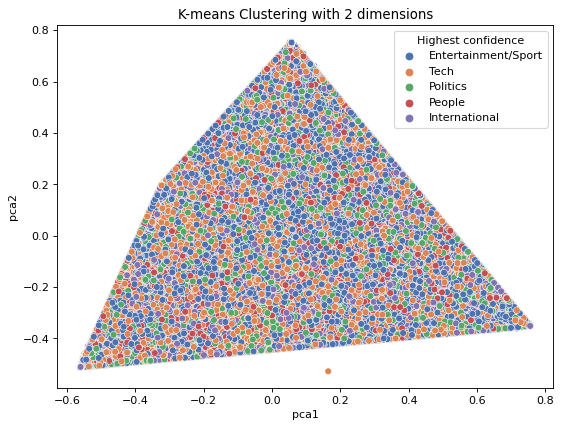

In [203]:
plt.figure(figsize=(8, 6), dpi=80)
sns.scatterplot(x="pca1", y="pca2", hue=mix['Highest confidence'], data=results, palette="deep")
plt.title('K-means Clustering with 2 dimensions')
plt.show()

##### Plotting based on the 'Cluster'from Kmeans

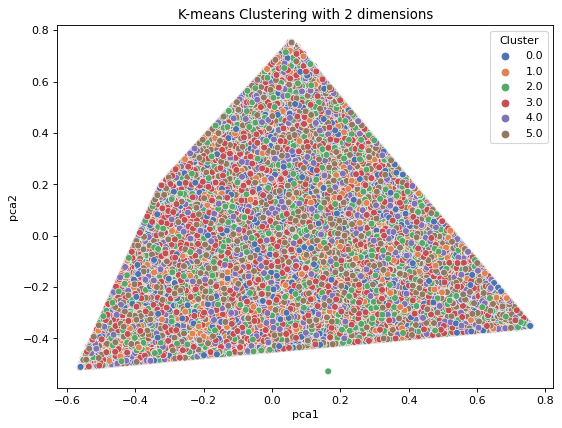

In [204]:
plt.figure(figsize=(8, 6), dpi=80)
sns.scatterplot(x="pca1", y="pca2", hue=mix['Cluster'], data=results, palette="deep")
plt.title('K-means Clustering with 2 dimensions')
plt.show()

Saving

In [205]:
mix.to_csv('MIX.csv', index=False)
mix.to_csv('MIX+index.csv')

In [206]:
mix[['Entertainment/Sport', 'Politics', 'International', 'Tech', 'People', 'Cluster']].to_csv('MIX_spider01.csv', index=False)

In [207]:
mix[['Entertainment/Sport', 'Politics', 'International', 'Tech', 'People', 'Highest confidence']].to_csv('MIX_spider02.csv', index=False)

In [208]:
mix[['Entertainment/Sport', 'Politics', 'International', 'Tech', 'People', 'Highest confidence', 'Cluster']].to_csv('MIX_spider03.csv', index=False)

In [210]:
mix[['content', 'clean']].to_csv('title+clean.csv', index=False)
mix[['content', 'vectorized']].to_csv('title+vectorized.csv', index=False)
mix[['content', 'tdf_vectorized']].to_csv('title+tdf_vectorized.csv', index=False)
mix[['content','clean','vectorized', 'tdf_vectorized']].to_csv('title+clean+vectorized+tdf_vectorized.csv', index=False)

#### LDA with TF_LDF

In [211]:
mix['Middle East'] = np.nan
mix['Entertainment/Sport'] = np.nan
mix['International'] = np.nan
mix['People'] = np.nan
mix['Economy'] = np.nan
mix['Highest confidence'] = np.nan
mix['Cluster'] = np.nan
mix.head()

,content,clean,vectorized,tdf_vectorized,Entertainment/Sport,Politics,International,Tech,People,Highest confidence,Cluster,Middle East,Economy
0,And never more so than in Showtime’s new...,"[showtim, seri, reviv, spoiler, ahead, episod,...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 0.015478959057446923), (1, 0.012365447563...",NaN,0.067401,NaN,0.032334,NaN,NaN,NaN,NaN,NaN
1,AlphaGo’s victory isn’t a defeat for hum...,"[alphago, victori, defeat, human, opportun, lo...","[(1, 3), (11, 1), (23, 1), (31, 2), (40, 1), (...","[(1, 0.020677359758448522), (11, 0.01030283518...",NaN,0.000000,NaN,0.644753,NaN,NaN,NaN,NaN,NaN
2,Super Deluxe built a weird internet empi...,"[super, delux, built, weird, internet, empir, ...","[(5, 1), (11, 1), (16, 1), (18, 4), (26, 1), (...","[(5, 0.01078139259054146), (11, 0.009709912536...",NaN,0.000000,NaN,0.098507,NaN,NaN,NaN,NaN,NaN
3,Steven Yang quit his job at Google in th...,"[steven, yang, quit, googl, summer, build, pro...","[(10, 1), (17, 1), (40, 3), (41, 14), (44, 1),...","[(10, 0.006474281424256228), (17, 0.0062626795...",NaN,0.000000,NaN,0.946584,NaN,NaN,NaN,NaN,NaN
4,Ahead of Black Panther’s 2018 theatrical...,"[ahead, black, panther, theatric, releas, marv...","[(8, 1), (15, 1), (49, 2), (60, 1), (257, 1), ...","[(8, 0.047099299273541895), (15, 0.06420103232...",NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


In [212]:
mix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177460 entries, 0 to 188731
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   content              177460 non-null  object 
 1   clean                177460 non-null  object 
 2   vectorized           177460 non-null  object 
 3   tdf_vectorized       177460 non-null  object 
 4   Entertainment/Sport  0 non-null       float64
 5   Politics             177460 non-null  float64
 6   International        0 non-null       float64
 7   Tech                 177460 non-null  float64
 8   People               0 non-null       float64
 9   Highest confidence   0 non-null       float64
 10  Cluster              0 non-null       float64
 11  Middle East          0 non-null       float64
 12  Economy              0 non-null       float64
dtypes: float64(9), object(4)
memory usage: 23.0+ MB


In [213]:
mix['Highest confidence'] = mix['vectorized'].apply(lambda x: sorted(lda_idf[x],key=lambda xs: xs[1])[-1][0])
mix.replace({0: 'Middle East', 1: 'Entertainment/Sport', 2:'International', 3:'People', 4:'Economy'}, inplace=True)
mix.head()

,content,clean,vectorized,tdf_vectorized,Entertainment/Sport,Politics,International,Tech,People,Highest confidence,Cluster,Middle East,Economy
0,And never more so than in Showtime’s new...,"[showtim, seri, reviv, spoiler, ahead, episod,...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 0.015478959057446923), (1, 0.012365447563...",NaN,0.067401,NaN,0.032334,NaN,Entertainment/Sport,NaN,NaN,NaN
1,AlphaGo’s victory isn’t a defeat for hum...,"[alphago, victori, defeat, human, opportun, lo...","[(1, 3), (11, 1), (23, 1), (31, 2), (40, 1), (...","[(1, 0.020677359758448522), (11, 0.01030283518...",NaN,Middle East,NaN,0.644753,NaN,Economy,NaN,NaN,NaN
2,Super Deluxe built a weird internet empi...,"[super, delux, built, weird, internet, empir, ...","[(5, 1), (11, 1), (16, 1), (18, 4), (26, 1), (...","[(5, 0.01078139259054146), (11, 0.009709912536...",NaN,Middle East,NaN,0.098507,NaN,Entertainment/Sport,NaN,NaN,NaN
3,Steven Yang quit his job at Google in th...,"[steven, yang, quit, googl, summer, build, pro...","[(10, 1), (17, 1), (40, 3), (41, 14), (44, 1),...","[(10, 0.006474281424256228), (17, 0.0062626795...",NaN,Middle East,NaN,0.946584,NaN,Economy,NaN,NaN,NaN
4,Ahead of Black Panther’s 2018 theatrical...,"[ahead, black, panther, theatric, releas, marv...","[(8, 1), (15, 1), (49, 2), (60, 1), (257, 1), ...","[(8, 0.047099299273541895), (15, 0.06420103232...",NaN,Middle East,NaN,Middle East,NaN,Entertainment/Sport,NaN,NaN,NaN


In [214]:
mix['Middle East'] = mix['vectorized'].apply(lambda x: (get_conf(lda[x], 0))).astype(float)
mix['Entertainment/Sport'] = mix['vectorized'].apply(lambda x: (get_conf(lda[x], 1))).astype(float)
mix['International'] = mix['vectorized'].apply(lambda x: (get_conf(lda[x], 2))).astype(float)
mix['People'] = mix['vectorized'].apply(lambda x: (get_conf(lda[x], 3))).astype(float)
mix['Economy'] = mix['vectorized'].apply(lambda x: (get_conf(lda[x], 4))).astype(float)
mix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177460 entries, 0 to 188731
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   content              177460 non-null  object 
 1   clean                177460 non-null  object 
 2   vectorized           177460 non-null  object 
 3   tdf_vectorized       177460 non-null  object 
 4   Entertainment/Sport  177460 non-null  float64
 5   Politics             177460 non-null  object 
 6   International        177460 non-null  float64
 7   Tech                 177460 non-null  object 
 8   People               177460 non-null  float64
 9   Highest confidence   177460 non-null  object 
 10  Cluster              0 non-null       float64
 11  Middle East          177460 non-null  float64
 12  Economy              177460 non-null  float64
dtypes: float64(6), object(7)
memory usage: 23.0+ MB


#### Clustering2

In [215]:
km = KMeans(n_clusters= 5, random_state= 42)
Clusters = km.fit_predict(mix[['Middle East', 'Entertainment/Sport', 'International', 'People', 'Economy']])

In [216]:
mix['Cluster'] = Clusters
mix.head(20)

,content,clean,vectorized,tdf_vectorized,Entertainment/Sport,Politics,International,Tech,People,Highest confidence,Cluster,Middle East,Economy
0,And never more so than in Showtime’s new...,"[showtim, seri, reviv, spoiler, ahead, episod,...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 0.015478959057446923), (1, 0.012365447563...",0.067397,0.067401,0.000000,0.032334,0.032305,Entertainment/Sport,3,0.899614,0.000000
1,AlphaGo’s victory isn’t a defeat for hum...,"[alphago, victori, defeat, human, opportun, lo...","[(1, 3), (11, 1), (23, 1), (31, 2), (40, 1), (...","[(1, 0.020677359758448522), (11, 0.01030283518...",0.000000,Middle East,0.000000,0.644753,0.644767,Economy,2,0.272255,0.081948
2,Super Deluxe built a weird internet empi...,"[super, delux, built, weird, internet, empir, ...","[(5, 1), (11, 1), (16, 1), (18, 4), (26, 1), (...","[(5, 0.01078139259054146), (11, 0.009709912536...",0.000000,Middle East,0.000000,0.098507,0.098515,Entertainment/Sport,3,0.869296,0.031722
3,Steven Yang quit his job at Google in th...,"[steven, yang, quit, googl, summer, build, pro...","[(10, 1), (17, 1), (40, 3), (41, 14), (44, 1),...","[(10, 0.006474281424256228), (17, 0.0062626795...",0.000000,Middle East,0.000000,0.946584,0.946584,Economy,2,0.052742,0.000000
4,Ahead of Black Panther’s 2018 theatrical...,"[ahead, black, panther, theatric, releas, marv...","[(8, 1), (15, 1), (49, 2), (60, 1), (257, 1), ...","[(8, 0.047099299273541895), (15, 0.06420103232...",0.000000,Middle East,0.000000,Middle East,0.000000,Entertainment/Sport,3,0.987983,0.000000
5,Facebook's Instant Articles promised to ...,"[facebook, instant, articl, promis, transform,...","[(0, 3), (1, 1), (18, 14), (20, 1), (22, 1), (...","[(0, 0.026299855256645136), (1, 0.007003259067...",0.000000,Middle East,0.000000,0.44554,0.445539,Economy,2,0.268365,0.285549
6,How a weapon against war became a weapon...,"[weapon, weapon, year, artist, technolog, enth...","[(1, 2), (7, 1), (14, 1), (27, 1), (44, 1), (5...","[(1, 0.025484391142309527), (7, 0.014274420127...",0.245238,0.245238,0.227809,0.167352,0.167349,International,0,0.211744,0.147859
7,Inside the big business of imagining the...,"[insid, busi, imagin, futur, dubai, world, loo...","[(10, 1), (14, 2), (18, 1), (24, 1), (33, 1), ...","[(10, 0.015919712714295927), (14, 0.0238766695...",0.018602,0.018523,0.036625,0.480232,0.480285,Entertainment/Sport,2,0.455548,0.000000
8,Legal threats and disgruntled clients: i...,"[legal, threat, disgruntl, client, insid, uber...","[(0, 1), (1, 1), (3, 2), (5, 1), (27, 1), (31,...","[(0, 0.014863445086004888), (1, 0.011873741002...",0.168619,0.168623,0.000000,0.467962,0.467958,Economy,2,0.285796,0.077289
9,Genius quietly laid off a bunch of its e...,"[genius, quiet, laid, bunch, engin, surviv, me...","[(3, 1), (11, 1), (18, 3), (31, 1), (40, 1), (...","[(3, 0.00841875072693792), (11, 0.012446204429...",0.000000,Middle East,0.000000,0.377199,0.377202,Economy,3,0.468296,0.153773


#### Applying PCA 2

In [217]:
reduced_data = PCA(n_components=2).fit_transform(mix[['Middle East', 'Entertainment/Sport', 'International', 'People', 'Economy']])

In [218]:
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

##### Plotting based on the 'Highest confidence' from LDA with TF_LDF

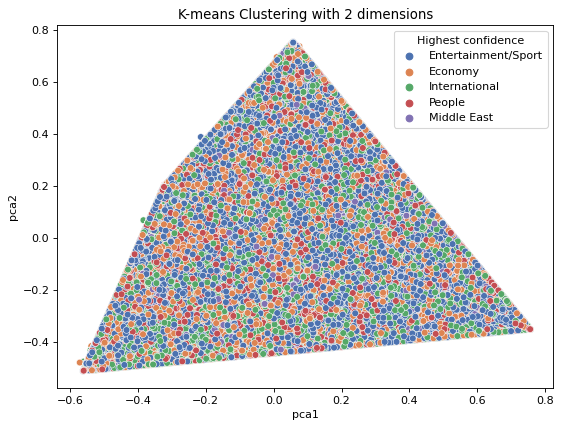

In [219]:
plt.figure(figsize=(8, 6), dpi=80)
sns.scatterplot(x="pca1", y="pca2", hue=mix['Highest confidence'], data=results, palette="deep")
plt.title('K-means Clustering with 2 dimensions')
plt.show()

##### Plotting based on the 'Cluster' from LDA with TF_LDF

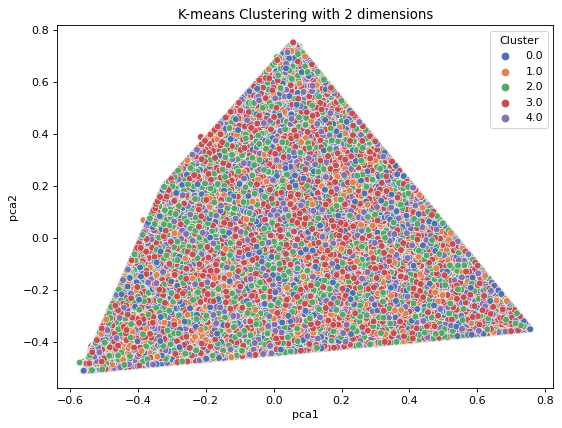

In [220]:
plt.figure(figsize=(8, 6), dpi=80)
sns.scatterplot(x="pca1", y="pca2", hue=mix['Cluster'], data=results, palette="deep")
plt.title('K-means Clustering with 2 dimensions')
plt.show()

Saving

In [ ]:
mix.to_csv('MIX__.csv', index=False)
mix.to_csv('MIX+index__.csv')
mix[['Middle East', 'Entertainment/Sport', 'International', 'People', 'Economy', 'Cluster']].to_csv('MIX_spider01__.csv', index=False)
mix[['Middle East', 'Entertainment/Sport', 'International', 'People', 'Economy', 'Highest confidence']].to_csv('MIX_spider02__.csv', index=False)
mix[['Middle East', 'Entertainment/Sport', 'International', 'People', 'Economy', 'Highest confidence', 'Cluster']].to_csv('MIX_spider03__.csv', index=False)

In [ ]:
mix[['content', 'clean']].to_csv('title+clean__.csv', index=False)
mix[['content', 'vectorized']].to_csv('title+vectorized__.csv', index=False)
mix[['content', 'tdf_vectorized']].to_csv('title+tdf_vectorized__.csv', index=False)